Jakub Cichowicz 148326 </br>
Łukasz Jakowski 148081

In [18]:
import numpy as np

import skimage as ski
import matplotlib.pyplot as plt



import pydicom
from pydicom.dataset import Dataset, FileDataset
import pydicom._storage_sopclass_uids

from ipywidgets import interact, IntSlider, Text, Button, VBox, DatePicker
import datetime

from skimage.exposure import rescale_intensity
from skimage.util import img_as_ubyte


In [11]:
def load_image(filename):
    image = ski.io.imread(filename)
    image = image.astype(np.float64)
    if len(image.shape) == 3:
        image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image


def show_steps(image):   
    plt.title("Steps")
    plt.imshow(image, cmap='gray')
    plt.show()
    
def show_image(image, title):
    plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.show()

def show_results(image, sinogram, invImage):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Image')

    axs[1].imshow(sinogram, cmap='gray')
    axs[1].set_title('Sinogram')

    axs[2].imshow(invImage, cmap='gray')
    axs[2].set_title('CT Result')

    plt.subplots_adjust(wspace=0.3)

    plt.show()

In [3]:
def radon(image, scans, detectors, arc_angle):
	center = np.array(image.shape) // 2     
	radius = np.sqrt(2) * max(center)       
	result_image = np.zeros((scans, detectors), dtype=image.dtype)
	alfa = np.deg2rad(arc_angle)        
	
	angles = np.linspace(0, 2 * np.pi, scans, endpoint=False)

	detector_angle_gap = alfa / (detectors - 1)

	for i, angle in enumerate(angles):
		
		emiter_pos = np.array([np.cos(angle), np.sin(angle)]) * radius + center
		
		for j in range(detectors):
			detector_angle = angle + np.pi - alfa / 2 + j * detector_angle_gap
			detector_pos = np.array([np.cos(detector_angle), np.sin(detector_angle)]) * radius + center
		
			y, x = ski.draw.line_nd(emiter_pos, detector_pos)

			in_square = []
			for it in range(len(x)):
				if 0 <= x[it] and x[it] < image.shape[1] and 0 <= y[it] and y[it] < image.shape[0]:
					in_square.append(True)
					continue
				in_square.append(False)

			if np.any(in_square):
				ray = []
				for k in range(len(x)):
					if in_square[k]:
						ray.append(image[y[k], x[k]])
						
				if len(ray) > 0:
					result_image[i, j] = sum(ray) / len(ray)
				else:
					result_image[i, j] = 0
			else:
				result_image[i, j] = 0

	return result_image

In [4]:

def inv_radon(sinogram, original_image_shape, scans, detectors, arc_angle):
    global inv_steps
    inv_steps = []
    center = np.array(original_image_shape) // 2     		
    radius = np.sqrt(2) * max(center)       
    result_image = np.zeros(original_image_shape, dtype=sinogram.dtype)
    alfa = np.deg2rad(arc_angle)        

    angles = np.linspace(0, 2 * np.pi, scans, endpoint=False)
    detector_angle_gap = alfa / (detectors - 1)
    for i, angle in enumerate(angles):
        emiter_pos = np.array([np.cos(angle), np.sin(angle)]) * radius + center

        for j in range(detectors):
            detector_angle = angle + np.pi - alfa / 2 + j * detector_angle_gap
            detector_pos = np.array([np.cos(detector_angle), np.sin(detector_angle)]) * radius + center

            y, x = ski.draw.line_nd(emiter_pos, detector_pos)

            in_square = []
            for it in range(len(x)):
                if 0 <= x[it] and x[it] < original_image_shape[1] and 0 <= y[it] and y[it] < original_image_shape[0]:
                    in_square.append(True)
                    continue
                in_square.append(False)
                                
            
            ray_x = []
            ray_y = []
            for it, element in enumerate(in_square):
                if element:
                    ray_x.append(x[it])
                    ray_y.append(y[it])

            for k in range(len(ray_y)):
                result_image[ray_y[k], ray_x[k]] += sinogram[i, j]
        inv_steps.append(result_image.copy())
    return result_image

In [5]:
def show_result_steps(n):
    show_steps(inv_steps[n-1])


def sliders(scans_, detectors_, arc_angle_, file_name_):
    global scans, detectors, arc_angle, image_name
    detectors = detectors_
    image_name = file_name_
    arc_angle = arc_angle_
    scans = scans_

In [69]:
scans = 180
detectors = 180
arc_angle = 180
image_name = None

inv_steps = []

interact(sliders,
    scans_=IntSlider(min=90, max=720, step=90, value=90, description='Scans'),
    detectors_=IntSlider(min=90, max=720, step=90, value=180, description='Detectors'),
    arc_angle_=IntSlider(min=45, max=270, step=45, value=180, description='Arc angle'),
    file_name_=Text(value='Kropka.jpg', description='File name'))

interactive(children=(IntSlider(value=90, description='Scans', max=720, min=90, step=90), IntSlider(value=180,…

<function __main__.sliders(scans_, detectors_, arc_angle_, file_name_)>

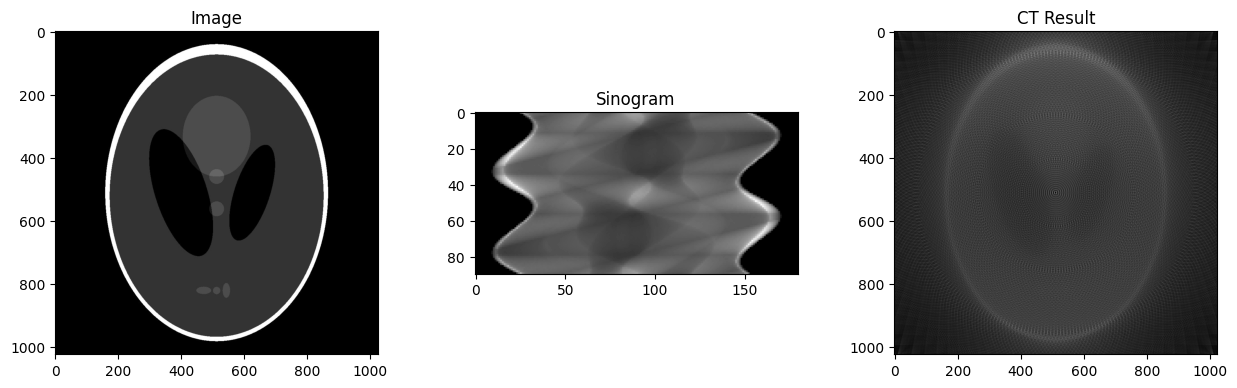

interactive(children=(IntSlider(value=1, description='n', max=90, min=1), Output()), _dom_classes=('widget-int…

<function __main__.show_result_steps(n)>

In [76]:
image = load_image(image_name)
sinogram = radon(image, scans, detectors, arc_angle)
invRadonTransform = inv_radon(sinogram, image.shape, scans, detectors, arc_angle)


show_results(image, sinogram, invRadonTransform)


interact(show_result_steps, n=IntSlider(value=1, min=1, max=len(inv_steps),step=1))

# DICOM

In [66]:
def save_dicom(file_name, img, patient_data):
    img_converted = img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    ds = FileDataset(None, {}, preamble=b"\0" * 128)

    ds.PatientName = patient_data[0]
    ds.PatientID = patient_data[3]
    ds.ImageComments = patient_data[1]
    ds.PatientBirthDate = patient_data[2]
    ds.AcquisitionDate = patient_data[4]


    ds.Modality = "CT"
    ds.file_meta = meta
    ds.is_little_endian = True
    ds.is_implicit_VR = False
    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7
    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1
    ds.PixelRepresentation = 0
    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()
    ds.Rows, ds.Columns = img_converted.shape
    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
    ds.PixelData = img_converted.tobytes()
    ds.save_as(file_name, write_like_original=False)


def import_dicom(file_name):
    ds = pydicom.filereader.dcmread(file_name)
    show_image(ds.pixel_array, 'DICOM file')
    print("Patient's full name: \t" + str(ds.PatientName))
    print("Patient ID: \t" + ds.PatientID)
    print("Image comments: \t" + ds.ImageComments)
    bd =  f"{ds.PatientBirthDate[:4]}-{ds.PatientBirthDate[4:6]}-{ds.PatientBirthDate[6:]}"
    print("Patient birth date: \t" +  bd )
    ac_date = f"{ds.AcquisitionDate[:4]}-{ds.AcquisitionDate[4:6]}-{ds.AcquisitionDate[6:]}"
    print("Acquisition date: \t" +  ac_date)



# DICOM INTERACTION

In [67]:
def saveInteractive(fileName, patientName, imageComments, birth_date, id):
    today = datetime.date.today()
    save_dicom(fileName, invRadonTransform, (patientName, imageComments, birth_date, id, today))
    print("File saved.")


tb_fileName = Text(description='File name:')
tb_patientName = Text(value='', description='Patient name:')
tb_imageComments = Text(value='', description='Comments:')
tb_patient_ID = Text(value='', description='ID:')
tb_patient_birth_date = DatePicker(description='Birth date')

save = Button(description='Save')
save.on_click(lambda x: saveInteractive(tb_fileName.value, tb_patientName.value, tb_imageComments.value, tb_patient_birth_date.value, tb_patient_ID.value))

box = VBox([tb_fileName, tb_patient_birth_date, tb_patientName,tb_patient_ID, tb_imageComments, save])
display(box)

File saved.


In [71]:
def import_interactive(file_name):
    import_dicom(file_name)

file_name_import = Text(description='File name:')

btn_save = Button(description='Import')
btn_save.on_click(lambda x: import_interactive(file_name_import.value))

box = VBox([file_name_import, btn_save])
display(box)
